In [1]:
import csv
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
from random import sample
from tqdm import tqdm
import scipy
from scipy import sparse
from scipy.sparse import *
from scipy import *
from numpy import linalg
from scipy.spatial.distance import hamming
import time
from networkx.algorithms.community import greedy_modularity_communities
import networkx.algorithms.community as nx_comm
import collections

## Supernodes

In [2]:
# facebook
partition_fb = {}
with open('fb_SNodes.txt') as file:
    for idx, line in enumerate(file):
        partition_fb[idx] = list(map(int,line.rstrip().split(' ')))[1:]

In [3]:
# lastfm
partition_fm = {}
with open('fm_SNodes.txt') as file:
    for idx, line in enumerate(file):
        partition_fm[idx] = list(map(int,line.rstrip().split(' ')))[1:]

In [4]:
# enron
partition_en = {}
with open('en_SNodes.txt') as file:
    for idx, line in enumerate(file):
        partition_en[idx] = list(map(int,line.rstrip().split(' ')))[1:]

In [5]:
#supernodes dictionary

supernode_fb = {}
for k,v in partition_fb.items():
    for el in v:
        supernode_fb[el] = k
        
supernode_fm = {}
for k,v in partition_fm.items():
    for el in v:
        supernode_fm[el] = k
        
supernode_en = {}
for k,v in partition_en.items():
    for el in v:
        supernode_en[el] = k

## Summary

In [6]:
# nx graph

fb = open('fb_S.csv', "r")
s_fb = nx.parse_edgelist(fb, delimiter=';', create_using=nx.Graph(), nodetype=int)

fm = open('fm_S.csv', "r")
s_fm = nx.parse_edgelist(fm, delimiter=';', create_using=nx.Graph(), nodetype=int)

en = open('en_S.csv', "r")
s_en = nx.parse_edgelist(en, delimiter=';', create_using=nx.Graph(), nodetype=int)

In [7]:
# adj matrices
S_fb = nx.adjacency_matrix(s_fb)

S_fm = nx.adjacency_matrix(s_fm)

S_en = nx.adjacency_matrix(s_en)

## Input

In [8]:
# input graphs

FB = open('fb.csv', "r")
G_fb = nx.parse_edgelist(FB, delimiter=',', create_using=nx.Graph(), nodetype=int)

FM = open('lastfm.csv', "r")
G_fm = nx.parse_edgelist(FM, delimiter=',', create_using=nx.Graph(), nodetype=int)

EN = open('en.csv', "r")
G_en = nx.parse_edgelist(EN, delimiter=',', create_using=nx.Graph(), nodetype=int)

## Supernodes density

In [18]:
# cluster : size
cluster={}
for k,v in partition_en.items():
    cluster[k] = len(v)
s = np.array([key for key, val in cluster.items() for _ in range(val)])

In [9]:
n = 36692
k = 6137

In [10]:
print('median', np.median(list(cluster.values())))
print('mean', np.mean(list(cluster.values())))
print('variance', np.var(list(cluster.values())))
print('max', np.max(list(cluster.values())))
print('max percentage', np.max(list(cluster.values()))/n*100)

median 2.0
mean 6.352589350838803
variance 72161.44694260237
max 22209
max percentage 60.52818052981577


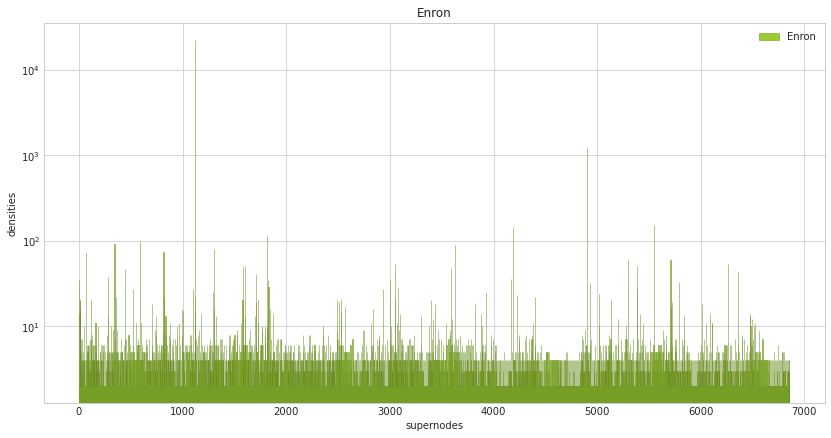

In [11]:
#cluster distribution

plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(s, bins=k, facecolor = 'yellowgreen', edgecolor='olivedrab',  linewidth=0.5, log=True, label = 'Enron')
plt.title('Enron') 
plt.xlabel('supernodes') 
plt.ylabel('densities') 
plt.legend(loc="upper right")
plt.show()

## Restored Graph

In [177]:
#feasible only with facebook graph
n = 4039
G_restored_fb = lil_matrix((n, n), dtype=int)
for i in tqdm(range(n)):
    for j in range(i+1):
        G_restored_fb[i,j] = 1 if s_fb.has_edge(supernode_fb[i], supernode_fb[j]) else 0
        G_restored_fb[j,i] =  G_restored_fb[i,j]

100%|██████████| 4039/4039 [01:14<00:00, 53.98it/s] 


### L2 Error

In [184]:
def adj_matrix(edge_list, n, is_directed, is_weighted):
    
    A = lil_matrix((n,n), dtype=float)
    f = open(edge_list)
    reader = csv.reader(f)
    
    for line in reader:
        if is_weighted:
            A[int(line[0]),int(line[1])] = int(line[2])
        else:
            A[int(line[0]),int(line[1])] = 1
        
        if is_directed==False:
            A[int(line[1]),int(line[0])] = A[int(line[0]),int(line[1])]  
        
    return A

In [185]:
A_fb = adj_matrix('fb.csv', 4039, False, False)

In [186]:
#l2 error
print('Error l2: with A_S', round(linalg.norm(A_fb.A-G_restored_fb.A)))

Error l2: with A_S 424


### Hamming Distance

In [193]:
# hamming distance
s = 0
for i in tqdm(range(n)):
    s += hamming(A_fb.A[i,:], G_restored_fb.A[i,:]) * len(A_fb.A)  
print("Hamming distance in adjacency queries", s/n)

100%|██████████| 4039/4039 [13:52<00:00,  4.85it/s]

Hamming distance in adjacency queries 44.54270859123545


### Degree Queries

In [192]:
#error degree queries percentage
s = []

for i in tqdm(range(n)):
    sumA = np.sum(A_fb[i,:])
    sumS = np.sum(G_restored_fb[i,:])
    s.append((abs(sumA - sumS))/sumA )
    
print("Average error in adjacency queries", np.mean(s))

100%|██████████| 4039/4039 [00:01<00:00, 2208.70it/s]

Average error in adjacency queries 1.014290450780583


## Global queries

In [14]:
# largest cc diamter and min cut size
largest_cc = max(nx.connected_components(G_fm), key=len)
subfm = G_fm.subgraph(largest_cc)

t0 = time.time()
print('start')
print('largest cc fm min cut size', tqdm(len(nx.minimum_node_cut(subfm))))
t1 = time.time()
print('Running time min cut size fm', round(t1-t0,2))

largest_cc = max(nx.connected_components(G_en), key=len)
suben = G_en.subgraph(largest_cc)

t0 = time.time()
print('largest cc diameter', nx.diameter(suben))
t1 = time.time()
print('Running time diameter en', round(t1-t0,2))


t0 = time.time()
print('largest cc min cut size', len(nx.minimum_node_cut(suben)))
t1 = time.time()
print('Running time min cut size en', round(t1-t0,2))

start


KeyboardInterrupt: 

In [38]:
# minimum cut
t0 = time.time()
nx.minimum_node_cut(s_fb)
t1 = time.time()
print(round(t1-t0,2))

60.26


In [39]:
#diameter
t0 = time.time()
print(nx.diameter(s_fb))
t1 = time.time()
print(round(t1-t0,2))

31
17.28


In [40]:
#average clustering
t0 = time.time()
nx.average_clustering(s_fb)
t1 = time.time()
print(round(t1-t0,2))

0.07


## Centrality measures

In [9]:
def precision(k, l1, l2):
    l3 = [value for value in l1 if value in l2]
    intersect = len(l3)
    return intersect/k

In [120]:
partition = partition_en
S = S_en

In [117]:
prG = nx.closeness_centrality(G_en)
prS = nx.closeness_centrality(s_en)

In [35]:
#normalization for pagerank
for i in prS.keys():
    prS[i] = prS[i]/len(partition[i])

In [65]:
#normalization for the degree centrality
for idx,i in enumerate(prS.keys()):
    if S[idx,idx] !=0:
        prS[i] = prS[i] + (len(partition[i]) - 1)#*S_prob[i,i]

In [121]:
#assign the centrality of the supernode to the nodes inside it
prSG = {}
for k,v in prS.items():
    for el in partition[k]:
        prSG[el] = v

In [127]:
# precision, recall and F1-measure
th = sorted(list(prSG.values()), reverse=True)[199]
for idx,el in enumerate(sorted(list(prSG.values()), reverse=True)):
    if el<th:
        print(idx)
        k2 = idx
        break
        
k1 = 200
l1 = sorted(prG, key=prG.get, reverse=True)[:k1]
l2 = sorted(prSG, key=prSG.get, reverse=True)[:k2]

# measures
r = precision(k1,l1,l2)
p = precision(k2,l1,l2)
print('Precision:', p)
print('Recall:', r)
print('f1 measure', 2*p*r/(p+r))

Precision: 0.0
Recall: 0.0


ZeroDivisionError: float division by zero

## Triangles

In [30]:
print('Input triangles', sum(nx.triangles(G_en).values()) / 3)
print('Summary triangles', sum(nx.triangles(s_en).values()) / 3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  """Entry point for launching an IPython kernel.


TypeError: unsupported operand type(s) for /: 'dict_values' and 'int'

In [210]:
partition = partition_en
s = s_en
k = 6135

In [215]:
#Riondato
t0=time.time()
t = 0
for i in tqdm(range(k)):
    n_i = len(partition[i])
    pi_ii = n_i / (n_i - 1) if n_i > 1 and s.has_edge(i,i) else 0
    t += scipy.special.binom(n_i,3) * pi_ii**3
    for j in range(i+1, k):
        pi_ij = 1 if s.has_edge(i,j) else 0
        n_j = len(partition[j])
        pi_jj = n_i / (n_i - 1) if n_i > 1 and s.has_edge(j,j) else 0
        t += pi_ij**2*(scipy.special.binom(n_i,2)*n_j*pi_ii + scipy.special.binom(n_j,2)*n_i*pi_jj)
        for w in range(j+1,k):
            n_w = len(partition[w])
            pi_jw = 1 if s.has_edge(j,w) else 0
            pi_wi = 1 if s.has_edge(w,i) else 0
            t += n_i*n_j*n_w*pi_ij*pi_jw*pi_wi
print("Expected Number of triangles: ", round(t))
t1 = time.time()
print('Running time', round(t1-t0,2))

 12%|█▏        | 721/6135 [5:35:05<41:56:11, 27.89s/it]


KeyboardInterrupt: 

In [216]:
t1 = time.time()
print('Running time', round(t1-t0,2))

Running time 20113.73


## Core decomposition

In [216]:
coreG = nx.core_number(G_en)

In [217]:
s_en.remove_edges_from(nx.selfloop_edges(s_en))
coreS = nx.core_number(s_en)

In [218]:
coreS_dict = {}
for k, v in coreS.items():
    for node in partition_en[k]:
        coreS_dict[node] = v 

In [219]:
#inner most core

l1 = [k for k in coreG.keys() if coreG[k]==max(coreG.values())]
l2 = [k for k in coreS_dict.keys() if coreS_dict[k]==max(coreS_dict.values())]

# measures
r = precision(len(l1),l1,l2)
p = precision(len(l2),l1,l2)
print('Precision:', p)
print('Recall:', r)
print('f1 measure', 2*p*r/(p+r))

Precision: 0.0
Recall: 0.0


ZeroDivisionError: float division by zero

## Shortest Path

In [79]:
# sample 100 couples of nodes 
random.seed(3)
largest_cc = max(nx.connected_components(G_en), key=len)
sample1 = sample(largest_cc, 100)
sample2 = sample(largest_cc, 100)
couples = [list(x) for x in zip(sample1, sample2)]

In [76]:
def shortest_distance(G,source):
    
    shortestDistance = float("inf")
    for n in G.neighbors(source): 
        currentDistance = nx.shortest_path_length(G, source=n, target=source,  method='dijkstra')
        shortestDistance = min(currentDistance, shortestDistance)
        
    return shortestDistance+1

In [35]:
def shortest_path(G, s, S, sample,supernode):  
    avg_err = []
    percentage_err = []

    for couple in sample:
        spG = nx.shortest_path_length(G, source=couple[0], target=couple[1], method='dijkstra')
        s_i = supernode[couple[0]]
        s_j = supernode[couple[1]]
        if s_i == s_j:
            if S[s_i, s_j] != 0:
                spS = 1
            else:
                spS = shortest_distance(s, s_i)

        else:
            spS = nx.shortest_path_length(s, source=s_i, target=s_j, method='dijkstra')
        avg_err.append(abs(spG-spS))
        percentage_err.append(abs(spG-spS)/spG)

    print('Average Error', np.mean(avg_err))
    print('Percentage Error', np.mean(percentage_err))

In [36]:
shortest_path(G_fm,s_fm, S_fm, couples, supernode_fm)

NodeNotFound: Either source 703 or target 2294 is not in G

## Connected Components

In [83]:
#Number
nx.number_connected_components(s_fm)

551

In [39]:
# largest cc size
largest_cc = max(nx.connected_components(s_en), key=len)
len(largest_cc)

1026

In [97]:
# largest cc diamter and min cut size
subs = s_fb.subgraph(largest_cc)
print('largest cc diameter', nx.diameter(subs))
print('largest cc min cut size', len(nx.minimum_node_cut(subs)))

largest cc diameter 6
largest cc min cut size 1


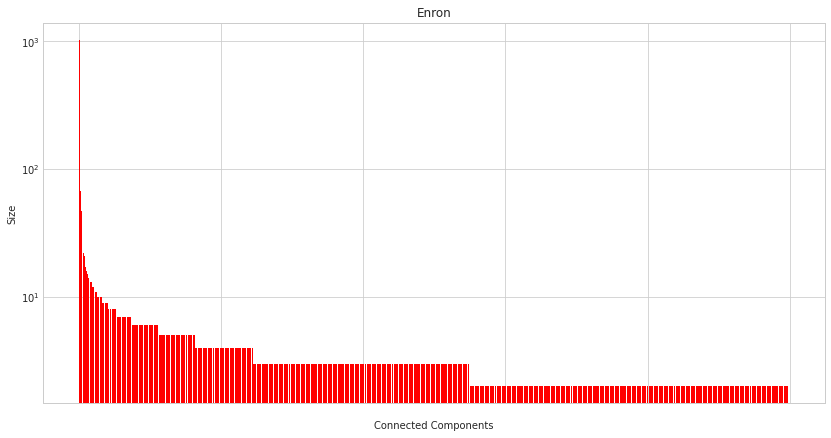

In [42]:
#bar plot of cc

cc = nx.connected_components(s_en)
data = [len(c) for c in sorted(cc, key=len, reverse=True)]

plt.figure(figsize=(14,7)) 
plt.bar(list(range(1000)), data[:1000], color = 'r', log=True)
plt.title('Enron') 
#plt.ylim(0,1050)
#plt.xlim(0,100)
plt.xlabel('Connected Components') 
plt.xticks(color='w')
plt.ylabel('Size') 
plt.show()

## Community Detection

In [179]:
w_G = nx.Graph()
lat_lon_to_index =  {}
for i, node in enumerate(s_en.nodes()):
    w_G.add_node(i, lat_lon=node)
    lat_lon_to_index[node] = i

for edge in s_en.edges():
    w_G.add_edge(lat_lon_to_index[edge[0]], lat_lon_to_index[edge[1]])

In [180]:
t0 = time.time()
community = greedy_modularity_communities(w_G, weight=None)
t1 = time.time()
print('Running time:', round(t1-t0,2)) 

Running time: 0.65


In [181]:
# Assing to each node the community of the supernode it belongs to

communityS = []
for idx in range(len(community)):
    comm_idx = []
    for el in community[idx]:
        for node in partition_en[el]:
            comm_idx.append(node)
    communityS.append(comm_idx)

In [188]:
flat_list = sorted(set([item for sublist in communityS for item in sublist]))

In [189]:
subs = G_en.subgraph(flat_list)

In [190]:
#modularity score
print(round(nx_comm.modularity(subs, communityS),2))

0.13
